# Importing Data/Preprocessing

In [1]:
import tensorflow as tf

In [2]:
BATCH_SIZE = 12
IMG_HEIGHT = 256
IMG_WIDTH = 256

#Dataset comes from https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/train",
    validation_split=0.15,
    subset="training",
    color_mode="grayscale",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/train",
    validation_split=0.15,
    subset="validation",
    color_mode="grayscale",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/test",
    color_mode="grayscale",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

Found 251 files belonging to 3 classes.
Using 214 files for training.
Found 251 files belonging to 3 classes.
Using 37 files for validation.
Found 66 files belonging to 3 classes.


In [3]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Pneumonia']


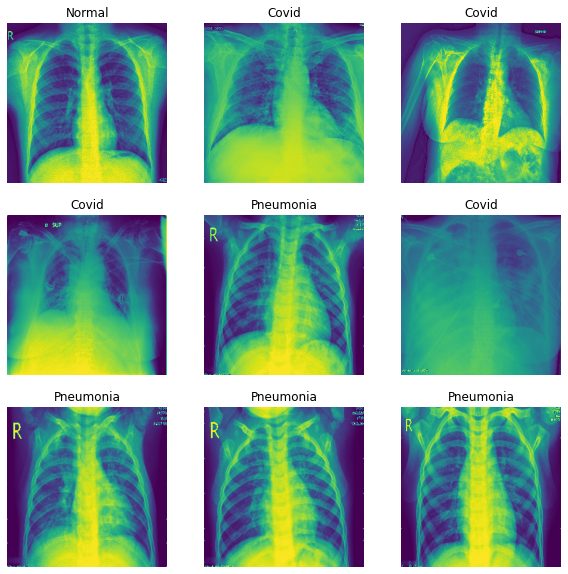

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(12, 256, 256, 1)
(12,)


# Building Model

In [6]:
from tensorflow.keras import layers

model = tf.keras.Sequential()

#Input
model.add(tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)))

#Preprocessing
model.add(layers.Rescaling(1./255))
model.add(layers.RandomFlip())

#Feature Learning
model.add(layers.Conv2D(16, 3, activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(4,4)))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(4,4)))
model.add(layers.Conv2D(64, 3, activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(4,4)))
model.add(tf.keras.layers.Dropout(0.1))

#Output
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(len(class_names), activation="softmax"))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                    

# Training Model

In [8]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
    metrics=["accuracy"])

In [9]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=30, verbose=1)

Epoch 1/30
18/18 [==============================] - 2s 94ms/step - loss: 1.0889 - accuracy: 0.3785 - val_loss: 1.0644 - val_accuracy: 0.4865
Epoch 2/30
18/18 [==============================] - 1s 80ms/step - loss: 1.0529 - accuracy: 0.5140 - val_loss: 0.9674 - val_accuracy: 0.5135
Epoch 3/30
18/18 [==============================] - 1s 81ms/step - loss: 0.9696 - accuracy: 0.5421 - val_loss: 0.8431 - val_accuracy: 0.6216
Epoch 4/30
18/18 [==============================] - 1s 80ms/step - loss: 0.7175 - accuracy: 0.7336 - val_loss: 0.5967 - val_accuracy: 0.8108
Epoch 5/30
18/18 [==============================] - 1s 81ms/step - loss: 0.5425 - accuracy: 0.7850 - val_loss: 0.5290 - val_accuracy: 0.8649
Epoch 6/30
18/18 [==============================] - 1s 81ms/step - loss: 0.3943 - accuracy: 0.8551 - val_loss: 0.4558 - val_accuracy: 0.8919
Epoch 7/30
18/18 [==============================] - 1s 81ms/step - loss: 0.4149 - accuracy: 0.8458 - val_loss: 0.5285 - val_accuracy: 0.8108
Epoch 8/30
18

# Testing Model

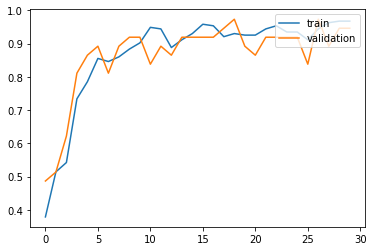

In [10]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend(loc="upper right")

plt.show()

In [11]:
model.evaluate(test_ds)

6/6 [==============================] - 0s 22ms/step - loss: 0.0933 - accuracy: 0.9697


[0.09333647042512894, 0.9696969985961914]

In [12]:
import numpy as np

predictions = model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

true_labels = np.concatenate([y for x, y in test_ds], axis=0)

6/6 [==============================] - 0s 22ms/step


In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predictions)